# Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create and Validate a BN
Ensure that all species dichtomous key sets actually map to the species we intend them to

In [ ]:
# CONFIGS

# network dependencies
!pip install pgmpy
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination


# loading dichtomous key data
import json
import os
import pandas as pd
import ast
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.5 MB/s eta 0:00:00


In [ ]:
# DIRS
ROOT = '/content/drive/MyDrive/Semester Project'
KEYS_DIR = os.path.join(ROOT, 'data', 'keys.csv')
DICHT_DIR = os.path.join(ROOT, 'data', 'feature_names.json')

In [ ]:
# DATA
df = pd.read_csv(KEYS_DIR, encoding="latin1")         # Ana's data on dichotomous keys
dicht = json.load(open(DICHT_DIR, "r"))               # the feature names (key names)

In [ ]:
# HELPERS
def parse_and_fix(x):
    """Parse Ana's stored vector reliably and convert:
       1 -> 1 (present)
       0 -> 0 (absent)
       anything else (nan, None, '', etc.) -> 2 (not evaluated)
    """
    # First, safely parse the nested string structure
    try:
        parsed = ast.literal_eval(x)
        parsed = ast.literal_eval(parsed)
    except Exception:
        # fallback: try more normalization
        cleaned = x.replace("nan", "None").replace("NaN", "None")
        parsed = ast.literal_eval(ast.literal_eval(cleaned))

    vec = []
    for v in parsed:
        if v in [1, "1", True]:
            vec.append(1)
        elif v in [0, "0", False]:
            vec.append(0)
        else:
            vec.append(2)  # NOT EVALUATED
    return np.array(vec, dtype=int)


def vector_is_valid(vec):
    if vec is None:
        return False
    if isinstance(vec, float) and np.isnan(vec):
        return False
    arr = np.array(vec, dtype=float)
    return not np.isnan(arr).any()

def cpd_to_df(cpd):
    species = list(cpd.state_names["Species"])
    df = pd.DataFrame(cpd.values,
                      index=cpd.state_names[cpd.variable],
                      columns=species)
    if len(df.index) == 2:
        df.index = ["No", "Yes"]
    return df

# validate these mappings
def predict_species(BN_model, evidence_dict, verbose=True):
    """
    Run BN inference given a feature dictionary (evidence).
    Returns (predicted_species, probability, full_distribution).
    """

    # set up inference engine
    inference = VariableElimination(BN_model)

    # run query
    query_result = inference.query(
        variables=["Species"],
        evidence=evidence_dict
    )

    # extract names and probs
    species_names = query_result.state_names["Species"]
    probs = query_result.values

    # most probable species
    max_idx = probs.argmax()
    predicted_species = species_names[max_idx]
    predicted_prob = probs[max_idx]

    if verbose:
        print("\n=== Bayesian Network Prediction ===")
        print("Predicted species:", predicted_species)
        print("Probability:", predicted_prob)
        print("\nFull distribution:")
        for sp, p in zip(species_names, probs):
            print(f"  {sp}: {p:.4f}")

    return predicted_species, predicted_prob, (species_names, probs)


import matplotlib.pyplot as plt

def plot_posterior(species, probs, top_k=15):
    """
    Plot the posterior distribution from the BN.
    Optionally show only the top_k species for clarity.
    """

    # Sort species by probability
    idx = probs.argsort()[::-1]       # descending
    species_sorted = [species[i] for i in idx]
    probs_sorted = probs[idx]

    # Optionally show only top-k most likely species
    species_plot = species_sorted[:top_k]
    probs_plot = probs_sorted[:top_k]

    plt.figure(figsize=(10, 5))
    plt.bar(species_plot, probs_plot)
    # plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel("Posterior Probability")
    plt.title("Bayesian Network Species Posterior (Top {} Species)".format(top_k))
    plt.tight_layout()
    plt.show()



In [ ]:
# clean the key vector
df["Full vector"] = df["Full vector"].apply(parse_and_fix)

In [ ]:
# clean names and drop dupes
df["Species"] = df["Species"].astype(str).str.strip()
df = df.drop_duplicates(subset="Species", keep="first")
df = df[df["Full vector"].apply(vector_is_valid)]

# fill out key value pairs : (species, json of feature names)
keys = {}

for species, row in df.iterrows():
    vec = row["Full vector"]

    # Length check
    if len(vec) != len(dicht):
        print(f"ERROR: Species '{row['Species']}' has vector length {len(vec)} (expected {len(dicht)})")
        continue

    # Build feature dictionary
    feats = {feat: int(val) for feat, val in zip(dicht, vec)}
    keys[row["Species"]] = feats

In [ ]:
from collections import defaultdict

# CHECK FOR DUPES
def build_equivalence_dict(keys):
    """
    Input:  keys = { species_name : {feature_name: value, ...}, ... }
    Output: equivalence = { species_name : [species_with_same_vector], ... }
    """

    # Step 1: Reverse-map feature vectors → list of species with that vector
    reverse = defaultdict(list)
    for sp, featdict in keys.items():
        vec_tuple = tuple(featdict.values())   # must be hashable
        reverse[vec_tuple].append(sp)

    # Step 2: Build equivalence mapping
    equivalence = {}
    for vec, species_list in reverse.items():
        # all species in this group map to the same species_list
        for sp in species_list:
            equivalence[sp] = species_list

    return equivalence, reverse

# === RUN IT ===
equivalence, reverse_groups = build_equivalence_dict(keys)

# Print duplicate groups nicely
print("\n=== Duplicate Feature Groups ===")
for vec, group in reverse_groups.items():
    if len(group) > 1:
        print(group)

# Example lookup
print("\nmarshallii group:", equivalence.get("marshallii"))
print("gambiae group:", equivalence.get("gambiae", ["gambiae"]))



=== Duplicate Feature Groups ===
['marshallii', 'hughi', 'letabensis', 'kosiensis']
['funestus', 'sergentii', 'cameroni']
['listeri', 'seretsei', 'azevedoi']
['somalicus', 'nili']
['argenteolobatus', 'murphyi']
['vanhoofi', 'hamoni']
['cydippis', 'squamosus']
['coustani', 'crypticus']

marshallii group: ['marshallii', 'hughi', 'letabensis', 'kosiensis']
gambiae group: ['gambiae']


In [ ]:
print(equivalence.get("ardensis"))

['ardensis']


In [ ]:
# build a network
rows = []
for species, featdict in keys.items():
    row = featdict.copy()
    row["Species"] = species
    rows.append(row)

df_bn = pd.DataFrame(rows)

def expand_species(df, n=100):
    expanded = []
    for _, row in df.iterrows():
        for _ in range(n):
            expanded.append(row.copy())
    return pd.DataFrame(expanded)

df_train = expand_species(df_bn, n=100)

# build model
from pgmpy.models import DiscreteBayesianNetwork
features = [c for c in df_train.columns if c != "Species"]
edges = [("Species", feat) for feat in features]

BN_model = DiscreteBayesianNetwork(edges)


# fit to cpd
from pgmpy.estimators import BayesianEstimator
BN_model.fit(df_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10)

In [ ]:
# validate the model with equivalence groups
validated = True
for species, featdict in keys.items():
    evidence = featdict.copy()
    pred, _, _ = predict_species(BN_model, evidence, verbose=False)

    allowed = equivalence.get(species, [species])
    if pred not in allowed:
        print(f"ERROR: Species '{species}' predicted as '{pred}'")
        validated = False

if validated:
    print("\n=== VALIDATION SUCCESSFUL ===")



=== VALIDATION SUCCESSFUL ===


# Load Dataset

In [ ]:
# load existing dataset from /processed
from datasets import load_from_disk

drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/Semester Project/data-augmentation/processed"
dataset = load_from_disk(DATASET_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %%capture
# import re
# if "COLAB_" not in "".join(os.environ.keys()):
#     !pip install unsloth
# else:
#     # Do this only in Colab notebooks! Otherwise use pip install unsloth
#     import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
#     xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
#     !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
#     !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
#     !pip install --no-deps unsloth
# !pip install transformers==4.56.2
# !pip install --no-deps trl==0.22.2

%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [ ]:
from unsloth import FastVisionModel
from peft import PeftModel
import torch

# 1. Load base model
base_model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit=True,
    dtype=torch.float16,
    use_gradient_checkpointing="unsloth",
)

# 2. Attach your LoRA adapters
lora_path = "/content/drive/MyDrive/Semester Project/data-augmentation/lora_model"
model = PeftModel.from_pretrained(base_model, lora_path)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.6: Fast Mllama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:
# load the basic key map (to map machine keys -> dichotomous keys)
KEYS_PATH = "/content/drive/MyDrive/Semester Project/data-augmentation/basic_key_map.json"

with open(KEYS_PATH, "r") as f:
    basic_key_map = json.load(f)

In [ ]:
# set up GPT client
!pip install openai
from openai import OpenAI

# set up the api key
os.environ["OPENAI_API_KEY"] = "insert your api key here"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
# post-processing GPT HELPER

allowed_keys = basic_key_map.keys()

# instruction:
def enforce_json_structure(raw_text, allowed_keys):
    allowed_keys = list(allowed_keys)

    prompt = f"""
You are a strict JSON validator.

Your ONLY tasks are:
1. Ensure the output is valid JSON.
2. Ensure the JSON contains exactly this set of keys:
{json.dumps(allowed_keys, indent=2)}
3. For any key already in the input with value "present", "absent", or "occluded",
   DO NOT MODIFY ITS VALUE.
4. If a key is missing, add it with value "occluded".
5. If a key has an invalid value, replace it with "occluded".
6. Return ONLY a JSON object. No comments, no explanations.

Input:
{raw_text}
    """

    response = client.chat.completions.create(
        model="gpt-4.1-mini",
        response_format={"type": "json_object"},
        messages=[{"role": "user", "content": prompt}],
    )

    return json.loads(response.choices[0].message.content)



# decode the json output by mapping the basic keys back to the dichtomous keys
# also map present -> 1
#          absent  -> 0
#          else    -> exclude from json

def decode_feature_json(model_json, key_map):
    decoded = {}
    all_basic_keys = set(key_map.keys())

    # 1. Ensure no missing/extra keys
    if set(model_json.keys()) != all_basic_keys:
        missing = all_basic_keys - set(model_json.keys())
        extra   = set(model_json.keys()) - all_basic_keys
        raise ValueError(f"Key mismatch. Missing={missing}, Extra={extra}")

    for basic_key, value in model_json.items():
        if basic_key not in key_map:
            raise KeyError(f"Unexpected key '{basic_key}' in model_json")

        v = value.strip().lower()

        # 2. Strict validity
        if v not in ("present", "absent", "occluded"):
            raise ValueError(f"Invalid value '{value}' for key '{basic_key}'")

        # 3. Map with NO silent fallback
        if v == "present":
            decoded[key_map[basic_key]] = 1
        elif v == "absent":
            decoded[key_map[basic_key]] = 0
        else:
            decoded[key_map[basic_key]] = 2

    return decoded


# Perform inference with Model

In [ ]:
# enable inference mode!
FastVisionModel.for_inference(model)

# select an image
im = 250

# select an image to infer from
image = dataset[im]["image"]

# instruction to the VLM
instruction = (
    "You are an expert entomologist. Describe accurately what you see in this "
    "image based on mosquito descriptions present in dichotomous keys."
)

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

In [ ]:
# perform inference
outputs = model.generate(
    **inputs,
    max_new_tokens=1000,
    use_cache=True,
    temperature=0.1,
    min_p=0.1
)

# decode into string
vlm_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
def clean_vlm_output(raw_output: str) -> str:
    # Split on 'assistant' and take everything after it
    if "assistant" in raw_output:
        cleaned = raw_output.split("assistant", 1)[1].strip()
    else:
        cleaned = raw_output.strip()

    return cleaned

cleaned_vlm_output = clean_vlm_output(vlm_output)

In [ ]:
print(json.dumps(cleaned_vlm_output, indent=2))

"{'2nd_main_dark_area_present_b4d0': 'occluded', '2nd_main_dark_area_wing_vein_1952': 'occluded', '2nd_main_dark_area_wing_vein_828c': 'occluded', '3rd_main_dark_area_costa_equal_5e00': 'occluded', '3rd_main_dark_area_much_longer_9b45': 'occluded', '3rd_main_dark_area_vein_1_990a': 'occluded', '3rd_main_dark_area_wing_vein_679b': 'occluded', '3rd_main_dark_area_wing_vein_bedc': 'occluded', 'abdominal_segments_laterally_projecting_tufts_scales_a455': 'absent', 'abdominal_terga_clothed_yellowish_scales_hindtarsomeres_a1dc': 'occluded', 'all_tarsi_completely_dark_wing_without_c886': 'occluded', 'apex_hindtibia_a_pale_streak_35_f5de': 'present', 'apical_pale_bands_hindtarsomeres_1_4_e889': 'present', 'apices_hindtarsomeres_3_4_dark_most_77ed': 'occluded', 'basal_02f6': 'occluded', 'basal_area_wing_vein_1_proximal_8981': 'occluded', 'basal_pale_band_maxillary_palpus_about_a31a': 'occluded', 'base_costa_1_pale_interruption_3rd_5b6c': 'occluded', 'base_costa_2_pale_interruptions_4fe9': 'occlu

In [ ]:
# post process the output
model_json = enforce_json_structure(cleaned_vlm_output, list(allowed_keys))

In [ ]:
import ast

if isinstance(model_json, str):
    model_json = ast.literal_eval(model_json)

In [ ]:
# post process the output
input = decode_feature_json(model_json, basic_key_map)

In [ ]:
print(json.dumps(input, indent=2))

{
  "Abdominal segments with laterally projecting tufts of scales on segments II-VII": 0,
  "Hindtarsus with at least last 2 hindtarsomeres entirely pale": 2,
  "Hindtarsomere 5 mainly or entirely dark, hindtarsomere 4 white": 2,
  "Legs speckled, sometimes sparsely": 2,
  "Wing entirely dark or with pale spots confined to costa and vein 1": 2,
  "Wing with at least 1 pale spot on basal 0.5 of costa": 2,
  "Maxillary palpus with apex dark": 2,
  "Maxillary palpus with 4 pale bands": 2,
  "Wing with pale interruption in 3rd main dark area (preapical dark spot) of vein 1, sometimes fused with preceding pale area": 2,
  "Wing with 2 pale spots on upper branch of vein 5": 2,
  "Wing almost entirely dark, costa without pale spots": 2,
  "Hindtarsomeres 1 to 5 entirely dark": 2,
  "Hindtarsomeres 1 and 2 with definite pale and dark rings in addition to apical pale bands": 2,
  "Hindtarsomeres 3 and 4 all white or narrowly dark basally, 5 all dark or at least basal 0.5 dark": 2,
  "Moderate-s

In [ ]:
# process through the BN
pred, _, _ = predict_species(BN_model, input, verbose=True)
print(pred)


=== Bayesian Network Prediction ===
Predicted species: brumpti
Probability: 0.37490575037560037

Full distribution:
  ardensis: 0.0000
  argenteolobatus: 0.0001
  aruni: 0.0000
  austenii: 0.0000
  azaniae: 0.0000
  azevedoi: 0.0000
  barberellus: 0.0000
  berghei: 0.0000
  bervoetsi: 0.0000
  brohieri: 0.0000
  brucei: 0.0000
  brumpti: 0.3749
  brunnipes: 0.0000
  buxtoni: 0.0000
  caliginosus: 0.0000
  cameroni: 0.0000
  carnevalei: 0.0000
  caroni: 0.0000
  carteri: 0.0000
  christyi: 0.0000
  cinctus: 0.0000
  cinereus: 0.0000
  concolor: 0.0000
  coustani: 0.0000
  cristipalpis: 0.0000
  crypticus: 0.0000
  culicifacies: 0.0000
  cydippis: 0.0000
  dancalicus: 0.0000
  daudi: 0.0000
  deemingi: 0.0000
  demeilloni: 0.0000
  demeilloni (Berg River form): 0.0000
  distinctus: 0.0000
  domicolus: 0.0000
  dthali: 0.0000
  dureni: 0.0000
  erepens: 0.0000
  faini: 0.0000
  flavicosta: 0.0000
  fontinalis: 0.0000
  freetownensis: 0.0000
  funestus: 0.0000
  fuscivenosus: 0.0000
  gab

In [ ]:
# what did the original predict?
test = enforce_json_structure(dataset[im]["caption"], basic_key_map)
test = decode_feature_json(test, basic_key_map)

def convert_for_bn(decoded, reverse_map):
    out = {}
    for full_text, val in decoded.items():
        if val in [0, 1] and full_text in reverse_map:
            short_key = reverse_map[full_text]
            out[short_key] = val
    return out

test = convert_for_bn(test, basic_key_map)

In [ ]:
# process through the BN
pred2, _, _ = predict_species(BN_model, test, verbose=True)



=== Bayesian Network Prediction ===
Predicted species: ardensis
Probability: 0.008620689655172412

Full distribution:
  ardensis: 0.0086
  argenteolobatus: 0.0086
  aruni: 0.0086
  austenii: 0.0086
  azaniae: 0.0086
  azevedoi: 0.0086
  barberellus: 0.0086
  berghei: 0.0086
  bervoetsi: 0.0086
  brohieri: 0.0086
  brucei: 0.0086
  brumpti: 0.0086
  brunnipes: 0.0086
  buxtoni: 0.0086
  caliginosus: 0.0086
  cameroni: 0.0086
  carnevalei: 0.0086
  caroni: 0.0086
  carteri: 0.0086
  christyi: 0.0086
  cinctus: 0.0086
  cinereus: 0.0086
  concolor: 0.0086
  coustani: 0.0086
  cristipalpis: 0.0086
  crypticus: 0.0086
  culicifacies: 0.0086
  cydippis: 0.0086
  dancalicus: 0.0086
  daudi: 0.0086
  deemingi: 0.0086
  demeilloni: 0.0086
  demeilloni (Berg River form): 0.0086
  distinctus: 0.0086
  domicolus: 0.0086
  dthali: 0.0086
  dureni: 0.0086
  erepens: 0.0086
  faini: 0.0086
  flavicosta: 0.0086
  fontinalis: 0.0086
  freetownensis: 0.0086
  funestus: 0.0086
  fuscivenosus: 0.0086
  g

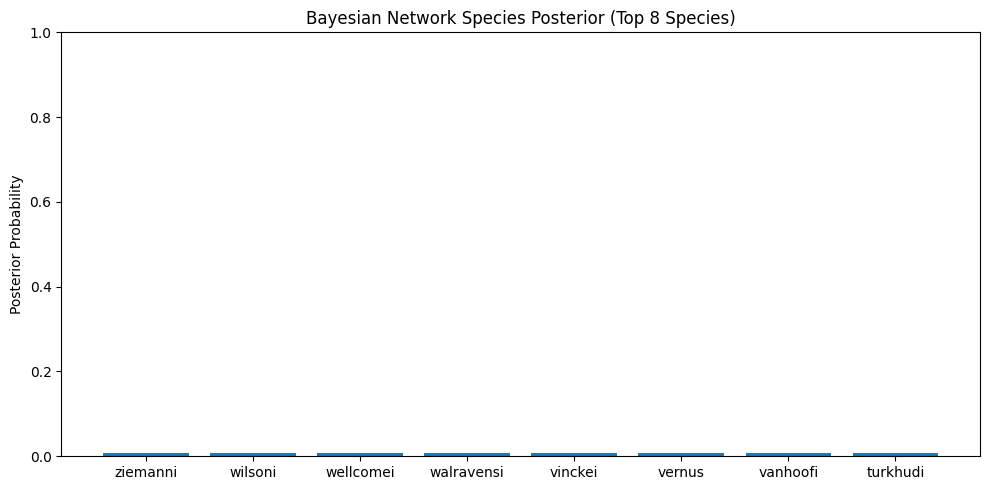

In [ ]:
# plot the distrubution
pred2, _, posterior = predict_species(BN_model, test, verbose=False)
species, probs = posterior
plot_posterior(species, probs, 8)

In [ ]:
# renormalization for fun

def restrict_and_renormalize(query_result, allowed_subset):
    """
    Given a pgmpy query_result for variable 'Species',
    filter to a subset of species and renormalize probabilities.

    Returns:
        best_name        – the MAP species inside allowed_subset
        best_prob        – its renormalized probability
        filtered_names   – list of species kept
        filtered_probs   – renormalized probabilities
    """
    # Extract original posterior
    species_names = query_result.state_names["Species"]
    probs = query_result.values  # array

    # Filter
    filtered_names = []
    filtered_probs = []

    for name, prob in zip(species_names, probs):
        if name in allowed_subset:
            filtered_names.append(name)
            filtered_probs.append(prob)

    filtered_probs = np.array(filtered_probs)

    # Handle edge case: none found
    if filtered_probs.sum() == 0:
        # Return uniform over subset
        uniform_prob = 1.0 / len(filtered_names)
        filtered_probs = np.array([uniform_prob] * len(filtered_names))
    else:
        # Renormalize
        filtered_probs /= filtered_probs.sum()

    # Pick best
    max_idx = filtered_probs.argmax()
    best_name = filtered_names[max_idx]
    best_prob = filtered_probs[max_idx]

    return best_name, best_prob, filtered_names, filtered_probs


In [ ]:
inference = VariableElimination(BN_model)
allowed_subset = ["funestus", "gambiae", "tenebrosus", "pharoensis", "coustani"]

query_result = inference.query(
    variables=["Species"],
    evidence=input
)

best_name, best_prob, names, probs = restrict_and_renormalize(query_result, allowed_subset)

print("Most likely species:", best_name)
print("Probability:", best_prob)
print("Distribution:")
for n, p in zip(names, probs):
    print(f"  {n}: {p:.3f}")


Most likely species: pharoensis
Probability: 0.5999655093210257
Distribution:
  coustani: 0.400
  funestus: 0.000
  gambiae: 0.000
  pharoensis: 0.600
  tenebrosus: 0.000


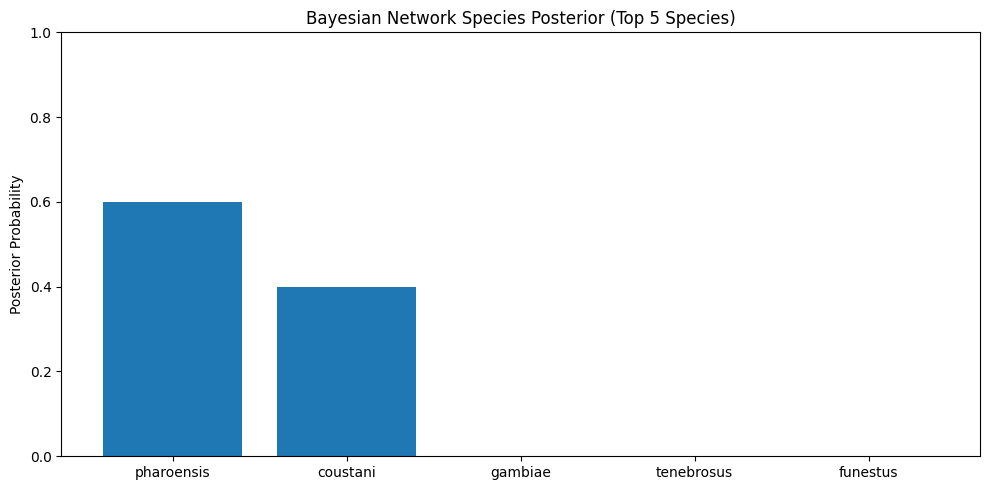

In [ ]:
plot_posterior(names, probs, 5)

# Bleu and Rouge Scores
note that it doesn't make sense to use these scores because they measure semantic similarity. This is just a demonstration. The actual metric for structured output should be a simple accuracy score for correct key output

In [ ]:
%%capture
!pip install evaluate
!pip install nltk
!pip install rouge_score
import evaluate

In [ ]:
print(json.dumps(cleaned_vlm_output, indent=2))
print(json.dumps(dataset[im]["caption"]))

"{'2nd_main_dark_area_present_b4d0': 'occluded', '2nd_main_dark_area_wing_vein_1952': 'occluded', '2nd_main_dark_area_wing_vein_828c': 'occluded', '3rd_main_dark_area_costa_equal_5e00': 'occluded', '3rd_main_dark_area_much_longer_9b45': 'occluded', '3rd_main_dark_area_vein_1_990a': 'occluded', '3rd_main_dark_area_wing_vein_679b': 'occluded', '3rd_main_dark_area_wing_vein_bedc': 'occluded', 'abdominal_segments_laterally_projecting_tufts_scales_a455': 'absent', 'abdominal_terga_clothed_yellowish_scales_hindtarsomeres_a1dc': 'occluded', 'all_tarsi_completely_dark_wing_without_c886': 'occluded', 'apex_hindtibia_a_pale_streak_35_f5de': 'present', 'apical_pale_bands_hindtarsomeres_1_4_e889': 'present', 'apices_hindtarsomeres_3_4_dark_most_77ed': 'occluded', 'basal_02f6': 'occluded', 'basal_area_wing_vein_1_proximal_8981': 'occluded', 'basal_pale_band_maxillary_palpus_about_a31a': 'occluded', 'base_costa_1_pale_interruption_3rd_5b6c': 'occluded', 'base_costa_2_pale_interruptions_4fe9': 'occlu

In [ ]:
#Compute Metrics
# Load the metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# set up the refs
ref1 = dataset[im]["caption"]

# set up the predictions


# Example data (can fill it with the dichtomous key stuff later...)
predictions = [
    json.dumps(input, indent=2),
]

references = [
    json.dumps(ref1, indent=2),
]

# bleu
bleu_result = bleu.compute(
    predictions=predictions,
    references=references
)

# rouge
rouge_result = rouge.compute(
    predictions=predictions,
    references=[r[0] for r in references]
)

print("BLEU:", json.dumps(bleu_result, indent=4))
print("ROUGE:", json.dumps(rouge_result, indent=4))

BLEU: {
    "bleu": 0.0,
    "precisions": [
        0.4615085536547434,
        0.10462854920264489,
        0.0031128404669260703,
        0.0
    ],
    "brevity_penalty": 1.0,
    "length_ratio": 1.0226640159045726,
    "translation_length": 2572,
    "reference_length": 2515
}
ROUGE: {
    "rouge1": 0.0,
    "rouge2": 0.0,
    "rougeL": 0.0,
    "rougeLsum": 0.0
}


# Accuracy of Inference Output Structure

In [ ]:
print(json.dumps(cleaned_vlm_output))
print(json.dumps(dataset[im]["caption"]))

"{'2nd_main_dark_area_present_b4d0': 'occluded', '2nd_main_dark_area_wing_vein_1952': 'occluded', '2nd_main_dark_area_wing_vein_828c': 'occluded', '3rd_main_dark_area_costa_equal_5e00': 'occluded', '3rd_main_dark_area_much_longer_9b45': 'occluded', '3rd_main_dark_area_vein_1_990a': 'occluded', '3rd_main_dark_area_wing_vein_679b': 'occluded', '3rd_main_dark_area_wing_vein_bedc': 'occluded', 'abdominal_segments_laterally_projecting_tufts_scales_a455': 'absent', 'abdominal_terga_clothed_yellowish_scales_hindtarsomeres_a1dc': 'occluded', 'all_tarsi_completely_dark_wing_without_c886': 'occluded', 'apex_hindtibia_a_pale_streak_35_f5de': 'present', 'apical_pale_bands_hindtarsomeres_1_4_e889': 'present', 'apices_hindtarsomeres_3_4_dark_most_77ed': 'occluded', 'basal_02f6': 'occluded', 'basal_area_wing_vein_1_proximal_8981': 'occluded', 'basal_pale_band_maxillary_palpus_about_a31a': 'occluded', 'base_costa_1_pale_interruption_3rd_5b6c': 'occluded', 'base_costa_2_pale_interruptions_4fe9': 'occlu

In [ ]:
# compare model_json vs dataset[im]["caption"] keys

pred_keys = set(model_json.keys())
actual_keys = set(dataset[im]["caption"].keys())

jaccard = len(actual_keys & pred_keys) / len(actual_keys | pred_keys)
print('Jaccard overlap: ', jaccard)


Jaccard overlap:  1.0
